In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pickle
from torch_geometric.loader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping

In [128]:
device = torch.device("cpu")

In [ ]:
## Loading node embedding data
node_embeddings = torch.load('./Graph Outputs/node_embeddings_initial.pt')
node_embeddings = node_embeddings.to(device)

print(node_embeddings.shape)

In [130]:
## Load Patient Subgraph Data
with open('./Graph Outputs/train_pg_subgraph.pkl', 'rb') as f:
    train_subgraphs = pickle.load(f)
with open('./Graph Outputs/val_pg_subgraph.pkl', 'rb') as f:
    val_subgraphs = pickle.load(f)
    
# print(train_subgraphs[0])

In [131]:
## map the node IDs of the node embeddings to the subgraph's node IDs
## global node embeddings : node_embeddings, where each row contains a node, columns are its features
## local IDs : the node IDs of the subgraph
## first step: get the global node IDs of the subgraph, the global ID corresponds to the row index of the node in node_embeddings
## second step: get the node embeddings of the subgraph by indexing the node_embeddings with the global node IDs
## third step: assign the node embeddings to the subgraph's x attribute
## In conclusion, we retrive the global IDs of subgraph, find out the corresponding row in node_embeddings, and assign the node embeddings to the subgraph's x attribute

for subgraph in train_subgraphs:
    global_node_ids = [int(key) for key in subgraph.node_mapping.keys()]
    subgraph.x = node_embeddings[global_node_ids]
    del subgraph.node_mapping  ## Remove node_mapping from Data object

for subgraph in val_subgraphs:
    global_node_ids = [int(key) for key in subgraph.node_mapping.keys()]
    subgraph.x = node_embeddings[global_node_ids]
    del subgraph.node_mapping

In [132]:
# ## View the mapping result
# print(train_subgraphs[0].x)
# print(train_subgraphs[0].x.shape)

In [133]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class DynamicLossPlotter:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

    def update(self, epoch, train_loss, val_loss):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        
        # Clear the current plot
        clear_output(wait=True)
        
        # Plot updated training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(self.epochs, self.train_losses, label='Training Loss', marker="o", color="blue")
        plt.plot(self.epochs, self.val_losses, label='Validation Loss', marker="o", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()


In [134]:
class PopulationLevelGraph(pl.LightningModule):
    def __init__(self, embedding_dim, num_patients, node_embeddings):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_patients = num_patients
        self.node_embeddings = node_embeddings
        self.val_losses = []
        self.train_outputs = []  # To store training outputs per batch
        self.val_outputs = []    # To store validation outputs per batch
        self.loss_plotter = DynamicLossPlotter()  # Initialize the plotter

        # GNN layers to process patient-specific subgraphs
        self.conv1 = GCNConv(embedding_dim, 128)
        self.conv2 = GCNConv(128, embedding_dim)

        # MLP to learn patient representations
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim),
        )

    def forward(self, data):
        # Ensure tensors are on the correct device
        device = self.node_embeddings.device
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)

        # Apply GNN layers
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        # Aggregate node features to create graph-level representation
        patient_rep = global_mean_pool(x, data.batch)
        return self.mlp(patient_rep)

    def compute_population_graph(self, patient_representations):
        # Compute pairwise similarities between patient representations
        latent_adj_matrix = torch.sigmoid(-torch.cdist(patient_representations, patient_representations, p=2))
        return latent_adj_matrix

    def compute_similarity_loss(self, patient_representations):
        # Encourage adjacency matrix to reflect similarity
        latent_adj_matrix = self.compute_population_graph(patient_representations)
        similarity_matrix = torch.mm(patient_representations, patient_representations.t())
        return F.mse_loss(latent_adj_matrix, torch.sigmoid(similarity_matrix))

    def compute_sparsity_loss(self, latent_adj_matrix):
        # Penalize non-zero elements to encourage sparsity
        return latent_adj_matrix.sum() * 1e-3

    def training_step(self, batch, batch_idx):
        # Move batch to the correct device
        batch = batch.to(self.node_embeddings.device)

        # Generate patient representations
        patient_representations = self.forward(batch)

        # Compute adjacency matrix
        latent_adj_matrix = self.compute_population_graph(patient_representations)

        # Compute losses
        similarity_loss = self.compute_similarity_loss(patient_representations)
        sparsity_loss = self.compute_sparsity_loss(latent_adj_matrix)

        # Total loss
        total_loss = similarity_loss + sparsity_loss
        self.log("train_loss", total_loss)

        # Save training loss for later
        self.train_outputs.append(total_loss.item())
        return total_loss

    def on_train_epoch_end(self):
        # Compute average training loss for the epoch
        if len(self.train_outputs) > 0:  # Ensure outputs are not empty
            avg_train_loss = sum(self.train_outputs) / len(self.train_outputs)
            self.train_outputs = []  # Reset for the next epoch
            self.log("avg_train_loss", avg_train_loss)


    def validation_step(self, batch, batch_idx):
        # Move batch to the correct device
        batch = batch.to(self.node_embeddings.device)
    
        # Generate patient representations
        patient_representations = self.forward(batch)
    
        # Compute adjacency matrix
        latent_adj_matrix = self.compute_population_graph(patient_representations)
    
        # Compute losses
        similarity_loss = self.compute_similarity_loss(patient_representations)
        sparsity_loss = self.compute_sparsity_loss(latent_adj_matrix)
    
        # Total loss
        val_loss = similarity_loss + sparsity_loss
        self.log("val_loss", val_loss, prog_bar=True) 
        
        # Save validation loss for later
        self.val_outputs.append(val_loss.item())
        return val_loss    

    def on_validation_epoch_end(self):
        # Compute average validation loss for the epoch
        if len(self.val_outputs) > 0:  # Ensure outputs are not empty
            avg_val_loss = sum(self.val_outputs) / len(self.val_outputs)
            self.val_outputs = []  # Reset for the next epoch
            self.val_losses.append(avg_val_loss)
            self.log("avg_val_loss", avg_val_loss)

            # Update the dynamic plot
            if self.current_epoch > 0:  # Ensure this is after the first epoch
                avg_train_loss = sum(self.train_outputs) / len(self.train_outputs)
                self.train_outputs = []  # Reset for the next epoch
                self.loss_plotter.update(self.current_epoch, avg_train_loss, avg_val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


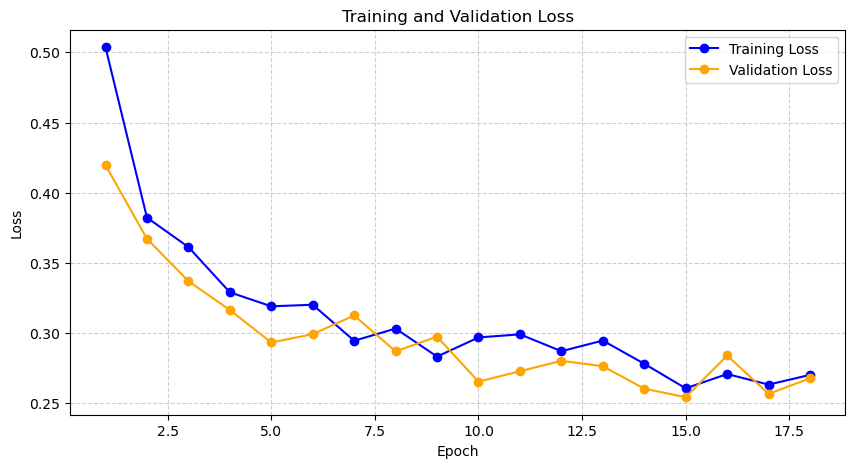

In [ ]:
train_loader = DataLoader(
    train_subgraphs,
    batch_size=128,
    shuffle=True,
)

val_loader = DataLoader(
    val_subgraphs,
    batch_size=128,
    shuffle=False,
)

model = PopulationLevelGraph(
    embedding_dim=node_embeddings.size(1),
    num_patients=len(train_subgraphs),
    node_embeddings=node_embeddings
)

early_stopping = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=5,          # Allow 5 epochs with no improvement
    mode="min",          # Stop when val_loss is minimized
    verbose=True
)

loss_plotter = DynamicLossPlotter()
trainer = pl.Trainer(max_epochs=100, accelerator="cpu", devices='auto')
trainer.fit(model, train_loader, val_loader)